# Brain Tumor Detection


In [1]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 607.6/607.6 kB 14.1 MB/s eta 0:00:0000:01


In [26]:
import pandas as pd
import numpy as np
import os
import ast
import cv2
from sklearn.model_selection import train_test_split
import shutil
from tqdm.notebook import tqdm
import tqdm.notebook as tq
import albumentations as albu
from albumentations import Compose
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
import matplotlib.image as mpimg
import PIL
from PIL import Image, ImageDraw, ImageFont
import shutil
from ultralytics import YOLO

# Dataset

In [27]:
dataset_path = '/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class'

In [28]:
os.mkdir('./datasets')
os.mkdir('./datasets/train')
os.mkdir('./datasets/train/images')
os.mkdir('./datasets/train/labels')
os.mkdir('./datasets/test')
os.mkdir('./datasets/test/images')
os.mkdir('./datasets/test/labels')
os.mkdir('./datasets/val')
os.mkdir('./datasets/val/images')
os.mkdir('./datasets/val/labels')

FileExistsError: [Errno 17] File exists: './datasets'

In [29]:
train_path = "./datasets/train"
test_path = "./datasets/test"
val_path = './datasets/val'

In [30]:
! cp {dataset_path}/images/train/* {train_path}/images/
! cp {dataset_path}/labels/train/* {train_path}/labels/
! cp {dataset_path}/images/test/* {test_path}/images/
! cp {dataset_path}/labels/test/* {test_path}/labels/

In [31]:
def count_files(folder_path):
    images_folder = os.path.join(folder_path, 'images')
    labels_folder = os.path.join(folder_path, 'labels')
    
    num_images = len(os.listdir(images_folder))
    num_labels = len(os.listdir(labels_folder))
    
    return num_images, num_labels


In [32]:
def remove_images_without_labels(folder_path):
    images_folder = os.path.join(folder_path, 'images')
    labels_folder = os.path.join(folder_path, 'labels')

    images = os.listdir(images_folder)
    labels = os.listdir(labels_folder)

    images_without_labels = set(images) - set([os.path.splitext(label)[0] + '.jpg' for label in labels])

    for image in images_without_labels:
        image_path = os.path.join(images_folder, image)
        os.remove(image_path)

    print(f"Image withot label {len(images_without_labels)} ")

In [33]:
train_path

'./datasets/train'

In [34]:
remove_images_without_labels(train_path)

Image withot label 14 


<p> Parte delle immagini del training vengono usate come validation set </p>

In [35]:
def create_validation_set(train_path, val_path, split_ratio=0.2):
    labels_dir = os.path.join(train_path, 'labels')
    images_dir = os.path.join(train_path, 'images')

    label_files = os.listdir(labels_dir)
    num_files_to_move = int(len(label_files) * split_ratio)
    files_to_move = random.sample(label_files, num_files_to_move)

    for file_name in files_to_move:
        src = os.path.join(labels_dir, file_name)
        dst = os.path.join(val_path, 'labels', file_name)
        shutil.move(src, dst)

    for file_name in files_to_move:
        img_name = os.path.splitext(file_name)[0] + '.jpg'
        src = os.path.join(images_dir, img_name)
        dst = os.path.join(val_path, 'images', img_name)
        shutil.move(src, dst)


create_validation_set(train_path, val_path)

In [36]:
ls

__notebook_source__.ipynb  datasets/


In [37]:
train_images, train_labels = count_files(train_path)
val_images, val_labels = count_files(val_path)
test_images, test_labels = count_files(test_path)

print(f"Number of files in the folder train: {train_images} image, {train_labels} label")
print(f"Number of files in the folder  val: {val_images} image, {val_labels} label")
print(f"Number of files in the folder test: {test_images} image, {test_labels} label")


Number of files in the folder train: 237 image, 237 label
Number of files in the folder  val: 109 image, 109 label
Number of files in the folder test: 75 image, 75 label


In [38]:
def show_random_images_from_train(train_path, num_rows, num_cols):
    images_folder = os.path.join(train_path, 'images')
    labels_folder = os.path.join(train_path, 'labels')

    image_files = os.listdir(images_folder)

    random_images = random.sample(image_files, num_rows * num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
    axes = axes.flatten()

    for i, image_file in enumerate(random_images):
        image_path = os.path.join(images_folder, image_file)
        label_file = os.path.splitext(image_file)[0] + '.txt'
        label_path = os.path.join(labels_folder, label_file)

        image = mpimg.imread(image_path)

        with open(label_path, 'r') as f:
            label = f.read().strip()

        ax = axes[i]
        ax.imshow(image, cmap='gray')
        ax.set_title(f'Label: {label}', fontsize=15)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

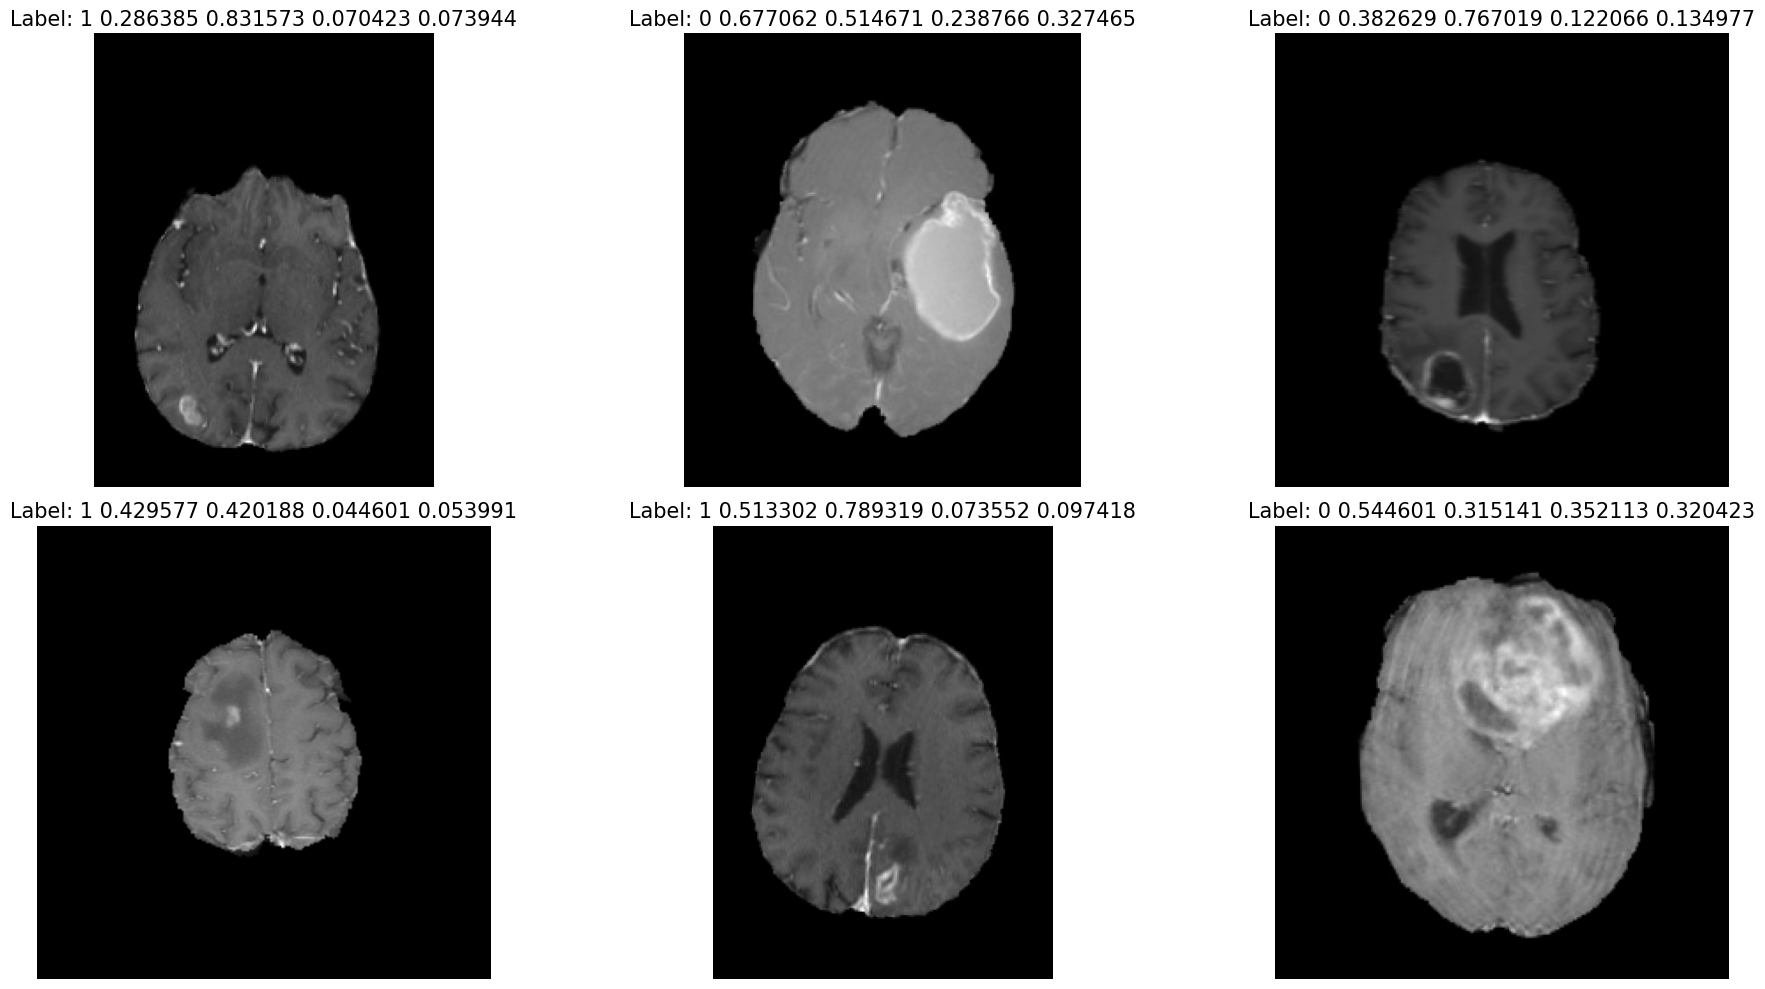

In [39]:
num_rows = 2
num_cols = 3
show_random_images_from_train(train_path, num_rows, num_cols)

# model Training

In [40]:
text = """
train: ./train
val: ./val

# number of classes
nc: 2

# class names
names: ['negative','positive']
"""
with open("./data.yaml", 'w') as file:
    file.write(text)

In [45]:
model = YOLO("yolov5s.pt")

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

100%|██████████| 17.7M/17.7M [00:00<00:00, 22.7MB/s]


In [43]:
!pip -q install wandb
!wandb disabled

W&B disabled.


In [49]:
!yolo task=detect mode=train model=yolov5s.pt data="./data.yaml" epochs=2

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

Ultralytics YOLOv8.0.141 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=detect, mode=train, model=yolov5s.pt, data=./data.yaml, epochs=2, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_

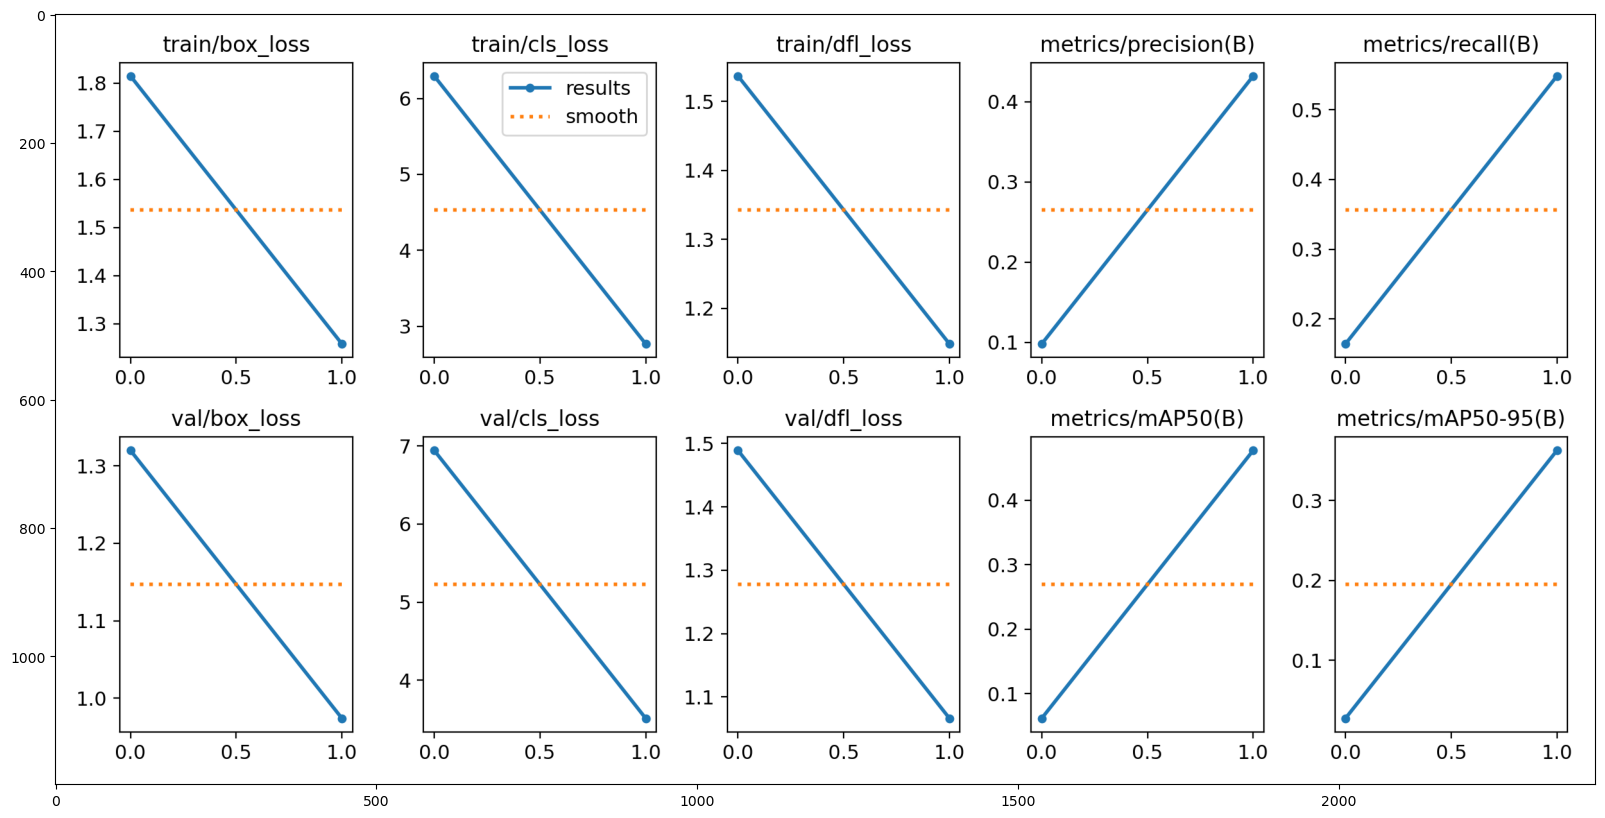

In [64]:
training_output_folder = '/kaggle/working/runs/detect/train4'

plt.figure(figsize=(20, 10))
img = Image.open(os.path.join(training_output_folder, 'results.png'))
plt.imshow(img)
plt.show()

In [55]:
!yolo task=detect mode=predict model=/kaggle/working/runs/detect/train4/weights/best.pt conf=0.25 source="/kaggle/working/datasets/test/images"

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Predicted vs Real

In [58]:
def draw_img_label(img, label, thickness=2):
    x_size, y_size = img.size
    label_text, cx, cy, w, h = label
    cx = cx * x_size
    cy = cy * y_size
    w = w * x_size
    h = h * y_size
    
    draw = ImageDraw.Draw(img)
    draw.rectangle(((cx - w/2, cy - h/2), (cx + w/2, cy + h/2)), outline="blue", width=thickness)
    draw.text((cx - w/2, cy - h/2 - 15), str(label_text), fill="red")
    return img


In [59]:
def show_predicted_vs_real(pred_path, real_path, label_path):
    pred_image = Image.open(pred_path)
    real_image = Image.open(real_path)

    with open(label_path, 'r') as f:
        label = tuple(map(float, f.readline().split()))  # Legge le coordinate come float

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(pred_image)
    axes[0].set_title('Immagine predetta')
    axes[0].axis('off')

    axes[1].imshow(real_image)
    axes[1].set_title('Immagine reale')
    image_with_label = draw_img_label(real_image, label)
    axes[1].imshow(image_with_label, cmap='gray')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


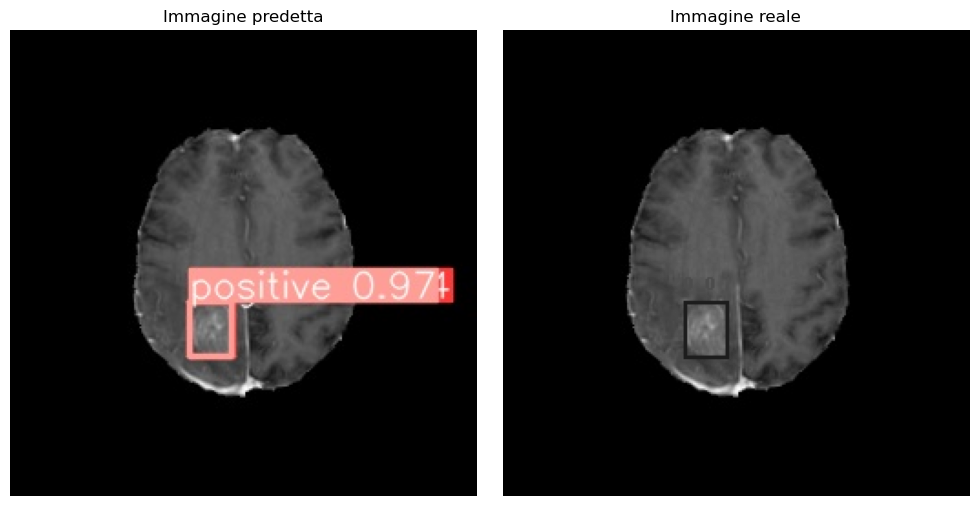

In [63]:
pred_list = os.listdir('/kaggle/working/runs/detect/predict/')
image_id = pred_list[8]

pred_path = os.path.join('/kaggle/working/runs/detect/predict/', image_id)
real_path = os.path.join('/kaggle/working/datasets/test/images', image_id)
label_path = os.path.join('/kaggle/working/datasets/test/labels', os.path.splitext(image_id)[0] + '.txt')

show_predicted_vs_real(pred_path,real_path,label_path )